# Kernel regression

<a target="_blank" href="https://colab.research.google.com/github/nickplas/Intro_to_ML_24-25/blob/main/notebooks/Lab-9.Kernel_Regression.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Linear data

First, we need some data we can play with. Let's create some arbitrary 2D samples.

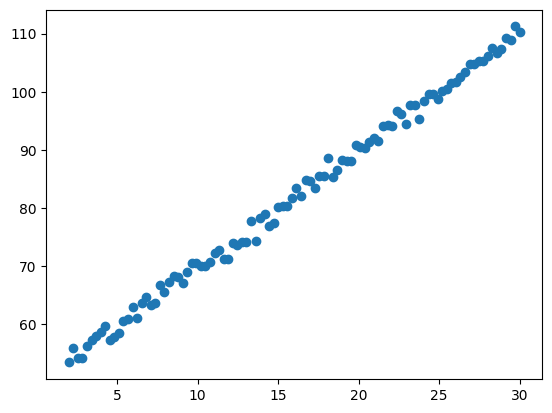

In [2]:
points = 100
sigma = 1

eps = np.random.normal(0,sigma,points)
x = np.linspace(2,30,points)
y = 2 * x + 50 + eps
x = x[:, np.newaxis]
plt.plot(x,y, 'o')

You can clearly see that there is a strong correlation between the two variables.

We know that the equation of a line is $y = wx$. Solving for $w$: $$w = X^{-1}y$$

Since we can not invert a matrix that isn’t square we simply make $X$ square by multiplying with its own transpose before inversion. To get the original shape back and by magic of math we multiply by the transpose again.
$$X^{-1} \sim (X^TX)^{-1} \, X^T$$
Plugging it in:
$$w=(X^{T}X)^{-1}\, X^{T} \, y$$

Dimensions: 
- $X\in R^{N\times d}$
- $X^{T}X\in R^{d\times d}$  

where $N$ is the number of points and $d$ is the dimension of each point.

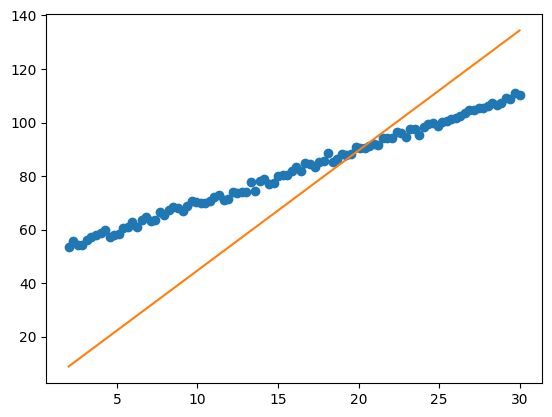

In [3]:
k = np.linalg.inv(np.dot(x.T, x))
w = np.dot(k, np.dot(x.T,y))
plt.plot(x,y,'o')
plt.plot(x, w*x)

Well we got a line, but it doesn’t really match the data yet. So what went wrong? The line equation that we started with $y=wx$ will always pass through $(0,0)$.

However, the regression line we expect from our data does not pass through $(0,0)$. So we have to adjust our line equation so that it’s y-value at $x=0$ can be fitted by our approach. We all know that we can simply add a constant to our line formula to end up with $y=wx+b$.

To deal with this situation, we just add an extra dimension to our data. Now the same multiplication of $X$ and $w$ will be $2$ dimensional as well. The matrix multiplication looks like this:

$$ \begin{bmatrix}
x_{0,0} \, w_0 + x_{0,1} \, w_1\\
\dots \\
x_{n,0} \, w_0 + x_{n,1} \, w_1
\end{bmatrix} = \begin{bmatrix}
y_0 \\ \dots \\ y_n
\end{bmatrix}
$$

Now if we set $x[:,1] = 1$ and we view $w[1]$ as $b$, we get the line equation with our bias. We don't even have to change our equations!

1. **Redo the calculations to add the constant $b$, then plot it.**  
*Tip: have a look at ```np.stack()```*

In [4]:
# before
x[:5]

array([[2.        ],
       [2.28282828],
       [2.56565657],
       [2.84848485],
       [3.13131313]])

In [5]:
# YOUR CODE
x = np.hstack((x, np.ones((x.shape[0], 1))))
k = np.linalg.inv(np.dot(x.T, x))
w = np.dot(k, np.dot(x.T,y))

In [6]:
# after
x[:5]

array([[2.        , 1.        ],
       [2.28282828, 1.        ],
       [2.56565657, 1.        ],
       [2.84848485, 1.        ],
       [3.13131313, 1.        ]])

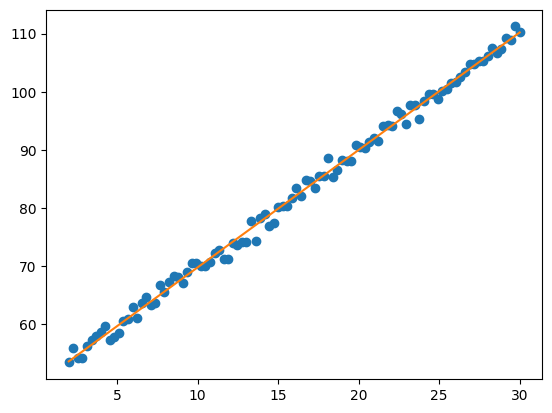

In [7]:
plt.plot(x[:,0], y, 'o')
plt.plot(x[:,0], x[:,0]*w[0] + w[1])

### Ridge regression
Sometimes the pseudo-inverse can run into trouble which can be avoided if we add a small value to our matrix before computing the inverse. This is known as *ridge regression*.


$$
w=(X^{T}X+\lambda \, I)^{-1}\, X^{T}y
$$

The effect is to mitigate the condition number of the matrix we are trying to invert. 

This is particularly important when we are dealing with a number of points which is $O(d)$ where $d$ is the number of dimensions (or parameters to estimate).
If this is the case it could happen that some rows or column are near to be **linearly dependent** and so the matrix cannot be inverted.
This is rarely the case, but the more the matrix approaches to be singular (determinant $\approx 0$) the worse the inverse we get.


## A note on numerical linear algebra

## NEVER DARE TO INVERT EXPLICITLY A MATRIX

Matrix inversion is an extremely expensive operation and it should be avoided at all costs since it is $O(n^3)$.
Usually the dimensions of the matrix we use scale with the number of points, or the number of parameters. 

Moreover, since we cannot be sure if our matrix is (approximately) singular, we can have huge and unreliable errors on the inverse.

More more over, if our starting matrix is *sparse*, so it contains a lot of zeros and can be stored efficiently in memory, it's inverse usually is *dense* so we end up consuming a lot of memory.

### What is the strategy?

If you are in a situation like the one above so something like 
$$
w=(X^{T}X+\lambda \, I)^{-1}\, X^{T}y
$$
The objective is to reframe it as the solution of a linear system.

$$(X^{T}X+\lambda \, I)w=X^{T} \, y$$


In [8]:
lam = 1
k = np.linalg.inv(np.dot(x.T,x) + lam * np.eye(x.shape[1]))
w_ridge = np.dot(k,np.dot(x.T,y))

#here below solve using the second strategy

xTx = np.dot(x.T, x)
k = lam * np.eye(x.shape[1])
w_ridge_no_inv = np.linalg.inv(xTx + k).dot(x.T).dot(y)

print(np.abs(w_ridge_no_inv - w_ridge).max())

3.552713678800501e-14


## Kernel Regression

What if our data isn't linear? (Rarely data is)

The entire framework of kernel regression revolves around of the idea of adding features explicitly or implicitly and getting into a space where our data is linearly separable.

Let's set up some non-linear data.

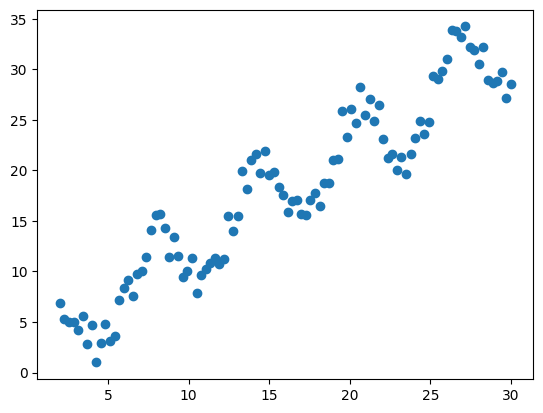

In [9]:
y = x[:,0] + 4 * np.sin(x[:,0])+ 4 * np.random.rand(x.shape[0])

plt.plot(x[:,0], y, 'o')

2. **Define the following kernel functions**
- Polynomial $$k(x_1,x_2) = (x_1^T \cdot x_2 +1 )^p $$
- Gaussian $$k(x_1, x_2) = \exp \bigg( - \frac{||x_1-x_2||^2}{2p^2} \bigg)$$
- Linear $$k(x_1,x_2) = x_1^T \cdot x_2 $$

Kernels must satisfy some requirements. 
A kernel function $K(x,y)$ is a function that can be written as the dot product of two vectors
$$ K(x,y) = < \phi(x) | \phi(y) >$$

By default a kernel should be *symmetric* $K(x,y) = K(y,x)$. The resulting matrix should be positive semidefinite

$\phi$ is called *feature map* and it is usually unknown. The space in which the vectors $\phi(.)$ live, is higher dimensionar w.r.t the one in which $x$ lives, possibly $\phi(x)$ is infinite dimensional.


In [119]:
def kernelFunc(x1, x2, kernel_type, param = 2):
    """
    args:
        x_1: first component, array
        x_2: second component, array
        kernel_type: used to specify which kernel to use, string
        param: p parameter
    
    output:
        Value of the kernel 
    """
    if kernel_type == "poly":
        if param <= 0:
            raise ValueError("Invalid exponent for the polynomial")
        return (np.dot(x1,x2.T) + 1)**param
    
    if kernel_type == "Gauss":
        if param == 0:
            raise ValueError("Invalid exponent for the Gauss")
        diff = x1 - x2
        return np.exp(-np.dot(diff, diff) / (2 * param**2))
    
    if kernel_type == "Linear":
        return np.dot(x1.T,x2)
    

In [11]:
# YOUR CODE - Compute K matrix
kernel_matrix_poly = kernelFunc(x, x, "poly")
kernel_matrix_gauss = kernelFunc(x, x, "Gauss", 3)
kernel_matrix_linear = kernelFunc(x, x, "Linear")

In [12]:
X_norm = np.sum(x**2, axis=1).reshape(-1, 1)
K = np.exp(-(X_norm - 2 * np.dot(x, x.T) + X_norm.T) / (2 * 3**2))

Before going on, notice how $$w = (X^TX + \lambda I )^{-1} X^Ty$$ 

is the same as 
$$w=X^T(XX^T  + \lambda I)^{-1}y.$$ 
This is needed since our kernel matrix is $n$ x $n$


Now we just take our linear regression and replace all dot products with kernel functions.

Assume we want to compute the value $y$ of an unknown observation $z$, by ignoring for a moment the regularization
$$
y(z)=z^Tw=z^T \, X^{T}(XX^{T})^{-1} \ y 
$$

The kernel should substitute dot product where they appear
$$
y(z) = \phi(z)^T \phi(X^T) (\phi(X)\phi(X^T))^{-1} \, y
$$
$$
y(z) = \alpha(z)  \, K^{-1} \, y
$$

with $$\alpha(z)= \begin{bmatrix}
k(z,x_0) \\ \dots \\ k(z,x_N) 
\end{bmatrix} \in R^{1\times N} $$

The Kernel matrix here is $K=XX^{T}\in R^{N\times N}$, where $N$ is the number of points.

Notice that we also have to embed the vector at which we evaluate the regression, here $z$. Putting this into code we get:


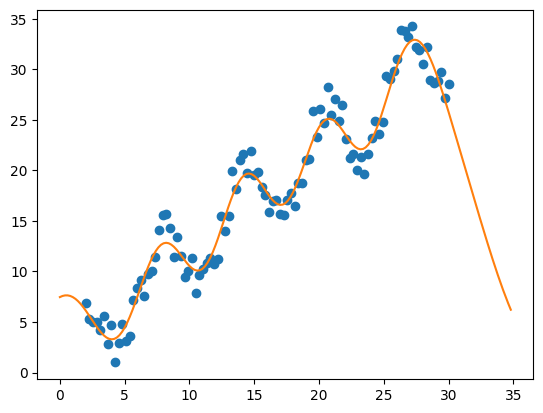

In [13]:
# calculate the inverse of K with ridge regression, then the weights
a = np.linalg.inv(K + 0.1 * np.eye(K.shape[0]))
w = np.dot(a,y)

x_pred = np.arange(0, 35, 0.2)
# same as before, add column of ones to represent the constant b
x_pred = np.stack([x_pred, np.ones(x_pred.shape[0])], axis=1).reshape(-1,2)
y_pred = np.zeros(x_pred.shape[0])

for i, x_p in enumerate(x_pred):
    k = np.zeros(x.shape[0])
    for j, row in enumerate(k):
        k[j] = kernelFunc(x_p, x[j,:], kernel_type="Gauss", param=3)
    y_pred[i] = np.dot(w,k)

plt.plot(x[:,0], y, 'o')
plt.plot(x_pred[:,0], y_pred)

## Putting all together

This function performs Kernel Ridge Regression (KRR) from scratch (S) on a given training dataset and uses the resulting model to predict the labels of a given test dataset.

The inputs to the function are:

- X_train: a numpy array representing the training data.
- y_train: a numpy array representing the target variable for the training data.
- X_test: a numpy array representing the test data.
- kernel_type: a string indicating the type of kernel to be used. 
- param: the parameter to be used in the kernel function.
- lam: a scalar indicating the regularization parameter for the KRR model.

The function first computes the kernel matrix $K$ using the training data and the kernel function specified by kernel_type and param. It then applies ridge regression to the kernel matrix to calculate the weights. Finally, it computes the predicted target values for the test data using the kernel function and the learned weights. The predicted labels are returned as an array.

3. **Write this function.**

In [120]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
def KRRS(X_train, y_train, X_test, kernel_type, param, lam):
    """
    args:
        X_train: train set, matrix
        y_train: labels for training, array
        X_test: test set, matrix
        kernel_type: used to specify which kernel to use, string
        param: p parameter
        lam: lambda parameter used in RR
    
    output:
        Predictions for the test set
    Non utilizzare np.linalg.inv, risolverlo come sistema lineare
    """


    # YOUR CODE
    if kernel_type == "poly":
        K = (np.dot(X_train,X_train.T) + 1)**param
    elif kernel_type == "Gauss":
        X_norm = np.sum(X_train**2, axis=1).reshape(-1, 1)
        K = np.exp(-(X_norm - 2 * np.dot(X_train, X_train.T) + X_norm.T) / (2 * param**2))
    elif kernel_type == "Linear":
        K = np.dot(X_train,X_train.T)
    else:
        raise ValueError(f"Unknown kernel type: {kernel_type}")
    
    a = np.linalg.solve(K + lam * np.eye(K.shape[0]), y_train)

    y_pred = np.zeros(X_test.shape[0])

    for i, x_p in enumerate(X_test):
        k = np.zeros(X_train.shape[0])
        for j, _ in enumerate(k):
            k[j] = kernelFunc(x_p, X_train[j,:], kernel_type=kernel_type, param=param)
        y_pred[i] = np.dot(a.ravel(),k.ravel())
    return y_pred



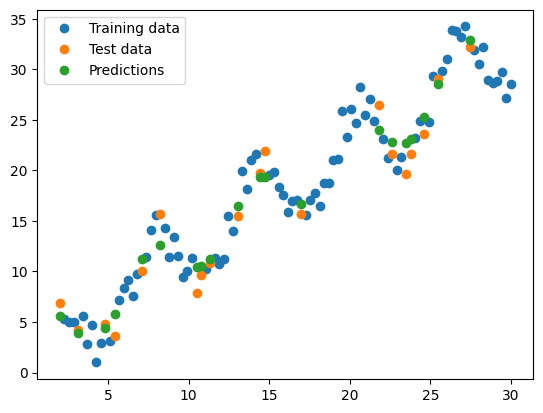

In [15]:

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

y_pred = KRRS(X_train, y_train, X_test, "Gauss", param=3, lam=0.1)

plt.plot(X_train[:, 0], y_train, 'o', label="Training data")
plt.plot(X_test[:, 0], y_test, 'o', label="Test data")
plt.plot(X_test[:, 0], y_pred, 'o', label="Predictions")
plt.legend()
plt.show()

In [16]:
mse = mean_squared_error(y_test, y_pred)

# Compute Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

n = len(y_test)  # number of samples
p = X_test.shape[1]  # number of predictors/features
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

evs = explained_variance_score(y_test, y_pred)

mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Print the errors
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
# R^2
print(f"R-squared: {r2}")
print(f"Adjusted R-squared: {adj_r2}")
# Explained Variance Score
print(f"Explained Variance Score: {evs}")
# Mean Absolute Percentage Error
print(f"Mean Absolute Percentage Error (MAPE): {mape}")

Mean Squared Error (MSE): 2.8263537869775677
Root Mean Squared Error (RMSE): 1.6811763104973754
Mean Absolute Error (MAE): 1.415027484728715
R-squared: 0.9593459249188041
Adjusted R-squared: 0.9545630925563104
Explained Variance Score: 0.9607206568116088
Mean Absolute Percentage Error (MAPE): 12.255535774619675


### Pre-made functions for KRR
- always [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html)

In [17]:
from sklearn.kernel_ridge import KernelRidge

n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
krr = KernelRidge(alpha=1.0, kernel = 'rbf') # other options: linear, polynomial, exponential, laplacian, chi2, sigmoid
krr.fit(X_test, y_pred)

KernelRidge(alpha=1.0, kernel='rbf')

## BONUS

Weather data, try to predict using kernel regression the temperature of successive days, use a train/test split like before

In [18]:
import pandas as pd

In [19]:

df = pd.read_csv("./weather_data.csv")

In [20]:
df.head()

,_time,stationId,airHumidity,airPressure,airTemperature,batteryV,solarV
0,2025-03-01T23:00:41+00:00,esp_outdoor,67.50,102903.91,5.99,3.97,0.00
1,2025-03-01T23:10:40+00:00,esp_outdoor,67.61,102916.12,5.96,4.02,0.01
2,2025-03-01T23:20:42+00:00,esp_outdoor,67.94,102904.33,5.83,3.95,0.00
3,2025-03-01T23:30:44+00:00,esp_outdoor,65.33,102915.70,6.47,3.95,0.00
4,2025-03-01T23:40:40+00:00,esp_outdoor,63.60,102917.73,6.70,4.02,0.01


In [21]:
import plotly_express as px
import plotly.graph_objects as go
import plotly

fig = px.line(df, x = "_time", y = "airTemperature")
fig.update_layout(template = "plotly_white")


In [22]:
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x = df["_time"], y = df["airTemperature"]), secondary_y = False
)

fig.add_trace(
    go.Scatter(x = df["_time"], y = df["solarV"]), secondary_y = True
)


fig.update_layout(template = "plotly_white")

In [23]:
df_mod1 = df.iloc[:, [0, 2, 3, 4, 5, 6]]

In [24]:
df_mod1.head()

,_time,airHumidity,airPressure,airTemperature,batteryV,solarV
0,2025-03-01T23:00:41+00:00,67.50,102903.91,5.99,3.97,0.00
1,2025-03-01T23:10:40+00:00,67.61,102916.12,5.96,4.02,0.01
2,2025-03-01T23:20:42+00:00,67.94,102904.33,5.83,3.95,0.00
3,2025-03-01T23:30:44+00:00,65.33,102915.70,6.47,3.95,0.00
4,2025-03-01T23:40:40+00:00,63.60,102917.73,6.70,4.02,0.01


In [25]:
time_seconds = pd.to_datetime(df_mod1.iloc[:,0].to_numpy(), format='mixed', dayfirst=True).astype('int64') / 10**9

In [26]:
df_mod1.loc[:,'_time'] = time_seconds

In [27]:
df_mod1.head()

,_time,airHumidity,airPressure,airTemperature,batteryV,solarV
0,1740870041.0,67.50,102903.91,5.99,3.97,0.00
1,1740870640.0,67.61,102916.12,5.96,4.02,0.01
2,1740871242.0,67.94,102904.33,5.83,3.95,0.00
3,1740871844.0,65.33,102915.70,6.47,3.95,0.00
4,1740872440.0,63.60,102917.73,6.70,4.02,0.01


In [28]:
df_mod1 = df_mod1.sort_values(by='_time')

In [66]:
X = df_mod1.iloc[:,[0,1,2,4,5]].to_numpy().astype(np.float64)
y = df_mod1.iloc[:,3].to_numpy().astype(np.float64)

In [67]:
split_ratio = 0.8
n_samples = X.shape[0]
split_index = int(n_samples * split_ratio)

X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]


In [153]:
# Fit the model and make predictions
param=1
lam=100000
y_pred = KRRS(X_train, y_train, X_test, kernel_type="poly", param=param, lam=lam)

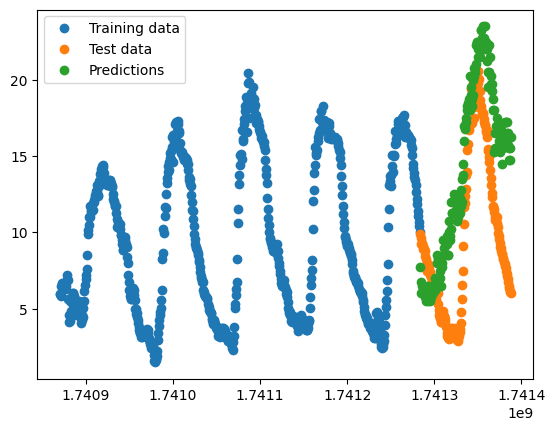

In [152]:
plt.plot(X_train[:, 0], y_train, 'o', label="Training data")
plt.plot(X_test[:, 0], y_test, 'o', label="Test data")
plt.plot(X_test[:, 0], y_pred, 'o', label="Predictions")
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
def cross_validate_krrs(X, y, kernel_type, param_grid, lambda_grid, n_splits=5):
    best_score = float('inf')
    best_params = {'param': None, 'lambda': None}

    for param in param_grid:
        for lam in lambda_grid:
            scores = []

            kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
            for train_index, val_index in kf.split(X):
                X_train, X_val = X[train_index], X[val_index]
                y_train, y_val = y[train_index], y[val_index]

                y_pred = KRRS(X_train, y_train, X_val,
                              kernel_type=kernel_type, param=param, lam=lam)
                score = mean_squared_error(y_val, y_pred)
                scores.append(score)

            avg_score = np.mean(scores)
            # print(f"param={param}, lambda={lam}, MSE={avg_score:.4f}")

            if avg_score < best_score:
                best_score = avg_score
                best_params = {'param': param, 'lambda': lam}

    return best_params, best_score

In [74]:
from joblib import Parallel, delayed


param_grid = np.linspace(0.1, 30000, 100)
lambda_grid = np.linspace(0.01, 10, 100)

def evaluate(param, lam):
    y_pred = KRRS(X_train, y_train, X_test, kernel_type="Gauss", param=param, lam=lam)
    error = np.mean((y_pred - y_test)**2)
    return (param, lam, error)

# Parallel loop
results = Parallel(n_jobs=-1)(delayed(evaluate)(p, l) for p in param_grid for l in lambda_grid)

# Find best params
best_param, best_lam, best_error = min(results, key=lambda x: x[2])

print(f"Best param: {best_param}, Best lambda: {best_lam}, Error: {best_error}")

Best param: 28787.882828282825, Best lambda: 0.01, Error: 75.58761423465789
